In [72]:
import sys
import pathlib
import numpy as np
import pandas as pd
import plotnine as p9
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import warnings

warnings.filterwarnings("ignore")
sys.path.insert(0, "../utils/")
from data_loader import load_data, load_train_test_data

In [73]:
# data path
data_directory = "../0.data-download/data/"

In [74]:
# load the training data
train_data = load_train_test_data(
    data_directory, train_or_test="train", load_gene_stats=False
)

In [75]:
# set a unique dataframe that can be appended from
training_df_age = train_data

# group by age and create new dataframes that can be appended to
groups = training_df_age.groupby("age_and_sex")
adult_effect_df = pd.DataFrame()
ped_effect_df = pd.DataFrame()
for name, training_df_age in groups:

    # append rows that contain Adult samples (male or female) to the new adult effect dataframe
    if name == "Adult_Male" or name == "Adult_Female" or name == "Adult_nan":
        adult_effect_df = adult_effect_df._append(training_df_age)
        adult_effect_df = adult_effect_df.reset_index(drop=True)

    # append rows that contain Pediatric samples (male ore female) to the new pediatric dataframe
    else:
        ped_effect_df = ped_effect_df._append(training_df_age)
        ped_effect_df = ped_effect_df.reset_index(drop=True)

In [76]:
# set a unique dataframe that can be appended from
training_df_sex = train_data

# group by sex and create new dataframes to be appended to
groups_sex = training_df_sex.groupby("age_and_sex")
male_effect_df = pd.DataFrame()
female_effect_df = pd.DataFrame()
for name, training_df_sex in groups_sex:

    # append rows that contain Male samples (Adult or Pediatric) to the new male effect dataframe and filter out samples that contain no gender info
    if (
        name == "Adult_Male"
        or name == "Pediatric_Male"
        and name != "Pediatric_nan"
        and name != "Adult_nan"
    ):
        male_effect_df = male_effect_df._append(training_df_sex)
        male_effect_df = male_effect_df.reset_index(drop=True)

    # append rows that contain Female samples (Adult or Pediatric) to the new female effect dataframe and filter out samples that contain no gender info
    elif (
        name == "Adult_Female"
        or name == "Pediatric_Female"
        and name != "Pediatric_nan"
        and name != "Adult_nan"
    ):
        female_effect_df = female_effect_df._append(training_df_sex)
        female_effect_df = female_effect_df.reset_index(drop=True)

In [77]:
print(adult_effect_df.shape)
adult_effect_df.head(3)

(569, 17109)


,ModelID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009),age_and_sex
0,ACH-001400,0.545022,0.410818,0.738383,0.888243,0.828010,0.809252,0.593792,0.592111,0.855294,...,0.342205,0.522279,0.390368,0.623943,0.224152,0.471891,0.516077,0.555002,0.457577,Adult_Female
1,ACH-001607,0.727401,0.625709,0.523563,0.575354,0.536610,0.516921,0.618747,0.539275,0.663328,...,0.542036,0.579059,0.668630,0.481543,0.478342,0.530550,0.456527,0.462609,0.638668,Adult_Female
2,ACH-002003,0.685706,0.701219,0.439781,0.690102,0.780568,0.625081,0.604389,0.812123,0.673089,...,0.483344,0.789318,0.633847,0.494836,0.396675,0.696592,0.381173,0.680479,0.636654,Adult_Female


In [78]:
print(ped_effect_df.shape)
ped_effect_df.head(3)

(101, 17109)


,ModelID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009),age_and_sex
0,ACH-000884,0.618550,0.521620,0.372861,0.618370,0.721107,0.444135,0.623689,0.615959,0.733665,...,0.312035,0.685545,0.455012,0.550887,0.722633,0.588025,0.454013,0.592175,0.549576,Adult_Unknown
1,ACH-001212,0.523111,0.573477,0.818520,0.749612,0.585728,0.639163,0.747495,0.473359,0.676317,...,0.583542,0.566879,0.486629,0.664624,0.475565,0.399055,0.495975,0.000000,0.488631,Pediatric_Female
2,ACH-000260,0.689003,0.597085,0.433876,0.541895,0.490266,0.478726,0.596272,0.612632,0.735341,...,0.420918,0.660812,0.532572,0.385328,0.437344,0.473560,0.527294,0.686939,0.514608,Pediatric_Female


In [79]:
print(male_effect_df.shape)
male_effect_df.head(3)

(378, 17109)


,ModelID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009),age_and_sex
0,ACH-000015,0.537008,0.628579,0.405618,0.586298,0.644211,0.625165,0.663636,0.612472,0.746107,...,0.611196,0.602114,0.583901,0.579924,0.548184,0.507604,0.385833,0.529040,0.586558,Adult_Male
1,ACH-001961,0.631645,0.604637,0.527678,0.566950,0.621833,0.588512,0.585049,0.623810,0.588127,...,0.429197,0.580953,0.690516,0.413069,0.464541,0.556673,0.484569,0.625129,0.536308,Adult_Male
2,ACH-000323,0.668470,0.594396,0.521253,0.682224,0.604673,0.622933,0.524289,0.659345,0.664237,...,0.409878,0.630856,0.561992,0.557153,0.301783,0.332616,0.330297,0.427734,0.655648,Adult_Male


In [80]:
print(female_effect_df.shape)
female_effect_df.head(3)

(285, 17109)


,ModelID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009),age_and_sex
0,ACH-001400,0.545022,0.410818,0.738383,0.888243,0.828010,0.809252,0.593792,0.592111,0.855294,...,0.342205,0.522279,0.390368,0.623943,0.224152,0.471891,0.516077,0.555002,0.457577,Adult_Female
1,ACH-001607,0.727401,0.625709,0.523563,0.575354,0.536610,0.516921,0.618747,0.539275,0.663328,...,0.542036,0.579059,0.668630,0.481543,0.478342,0.530550,0.456527,0.462609,0.638668,Adult_Female
2,ACH-002003,0.685706,0.701219,0.439781,0.690102,0.780568,0.625081,0.604389,0.812123,0.673089,...,0.483344,0.789318,0.633847,0.494836,0.396675,0.696592,0.381173,0.680479,0.636654,Adult_Female


In [81]:
# drop the string values from all dataframes
adult_effect_df_float = adult_effect_df.drop(
    columns=["ModelID", "age_and_sex"]
)
ped_effect_df_float = ped_effect_df.drop(columns=["ModelID", "age_and_sex"])

male_effect_df_float = male_effect_df.drop(columns=["ModelID", "age_and_sex"])
female_effect_df_float = female_effect_df.drop(
    columns=["ModelID", "age_and_sex"]
)

effect_df = train_data.drop(columns="age_and_sex")
effect_df = effect_df.set_index("ModelID")

In [82]:
# t_test comparing gene dependencies in adult vs pediatric samples
t_test = ttest_ind(adult_effect_df_float, ped_effect_df_float)
t_test = pd.DataFrame(t_test).T
t_test.columns = ["t_stat", "p_value"]
print(t_test.shape)
t_test.head(3)

(17107, 2)


,t_stat,p_value
0,2.641547,0.008446
1,-1.369684,0.171246
2,-0.141305,0.887672


In [83]:
# t_test comparing gene dependencies in male vs female samples
t_test_sex = ttest_ind(male_effect_df_float, female_effect_df_float)
t_test_sex = pd.DataFrame(t_test_sex).T
t_test_sex.columns = ["t_stat", "p_value"]
print(t_test_sex.shape)
t_test_sex.head(3)

(17107, 2)


,t_stat,p_value
0,-0.704334,0.481473
1,1.143283,0.253335
2,1.189012,0.234862


In [84]:
print(effect_df.shape)
effect_df.head(3)

(670, 17107)


,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),AADAC (13),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
ModelID,,,,,,,,,,,,,,,,,,,,,
ACH-001054,0.542404,0.714346,0.584461,0.706183,0.533871,0.699038,0.685953,0.641576,0.628061,0.304791,...,0.331937,0.472316,0.627318,0.572680,0.715287,0.522028,0.366138,0.486525,0.638275,0.483384
ACH-000015,0.537008,0.628579,0.405618,0.586298,0.644211,0.625165,0.663636,0.612472,0.746107,0.422420,...,0.446373,0.611196,0.602114,0.583901,0.579924,0.548184,0.507604,0.385833,0.529040,0.586558
ACH-001961,0.631645,0.604637,0.527678,0.566950,0.621833,0.588512,0.585049,0.623810,0.588127,0.470841,...,0.544518,0.429197,0.580953,0.690516,0.413069,0.464541,0.556673,0.484569,0.625129,0.536308


In [85]:
# calculate variance of each gene then send the results plus the gene info into a new dataframe
variance = effect_df.var()
variance_list = variance.tolist()
column_names = ["variance"]
variance_df = pd.DataFrame(variance, columns=column_names)
variance_df = variance_df.sort_index(ascending=True).reset_index()
variance_df = variance_df.rename(columns={"index": "gene_ID"})
print(variance_df.shape)
variance_df.head(3)

(17107, 2)


,gene_ID,variance
0,A1BG (1),0.012890
1,A1CF (29974),0.007995
2,A2M (2),0.016177


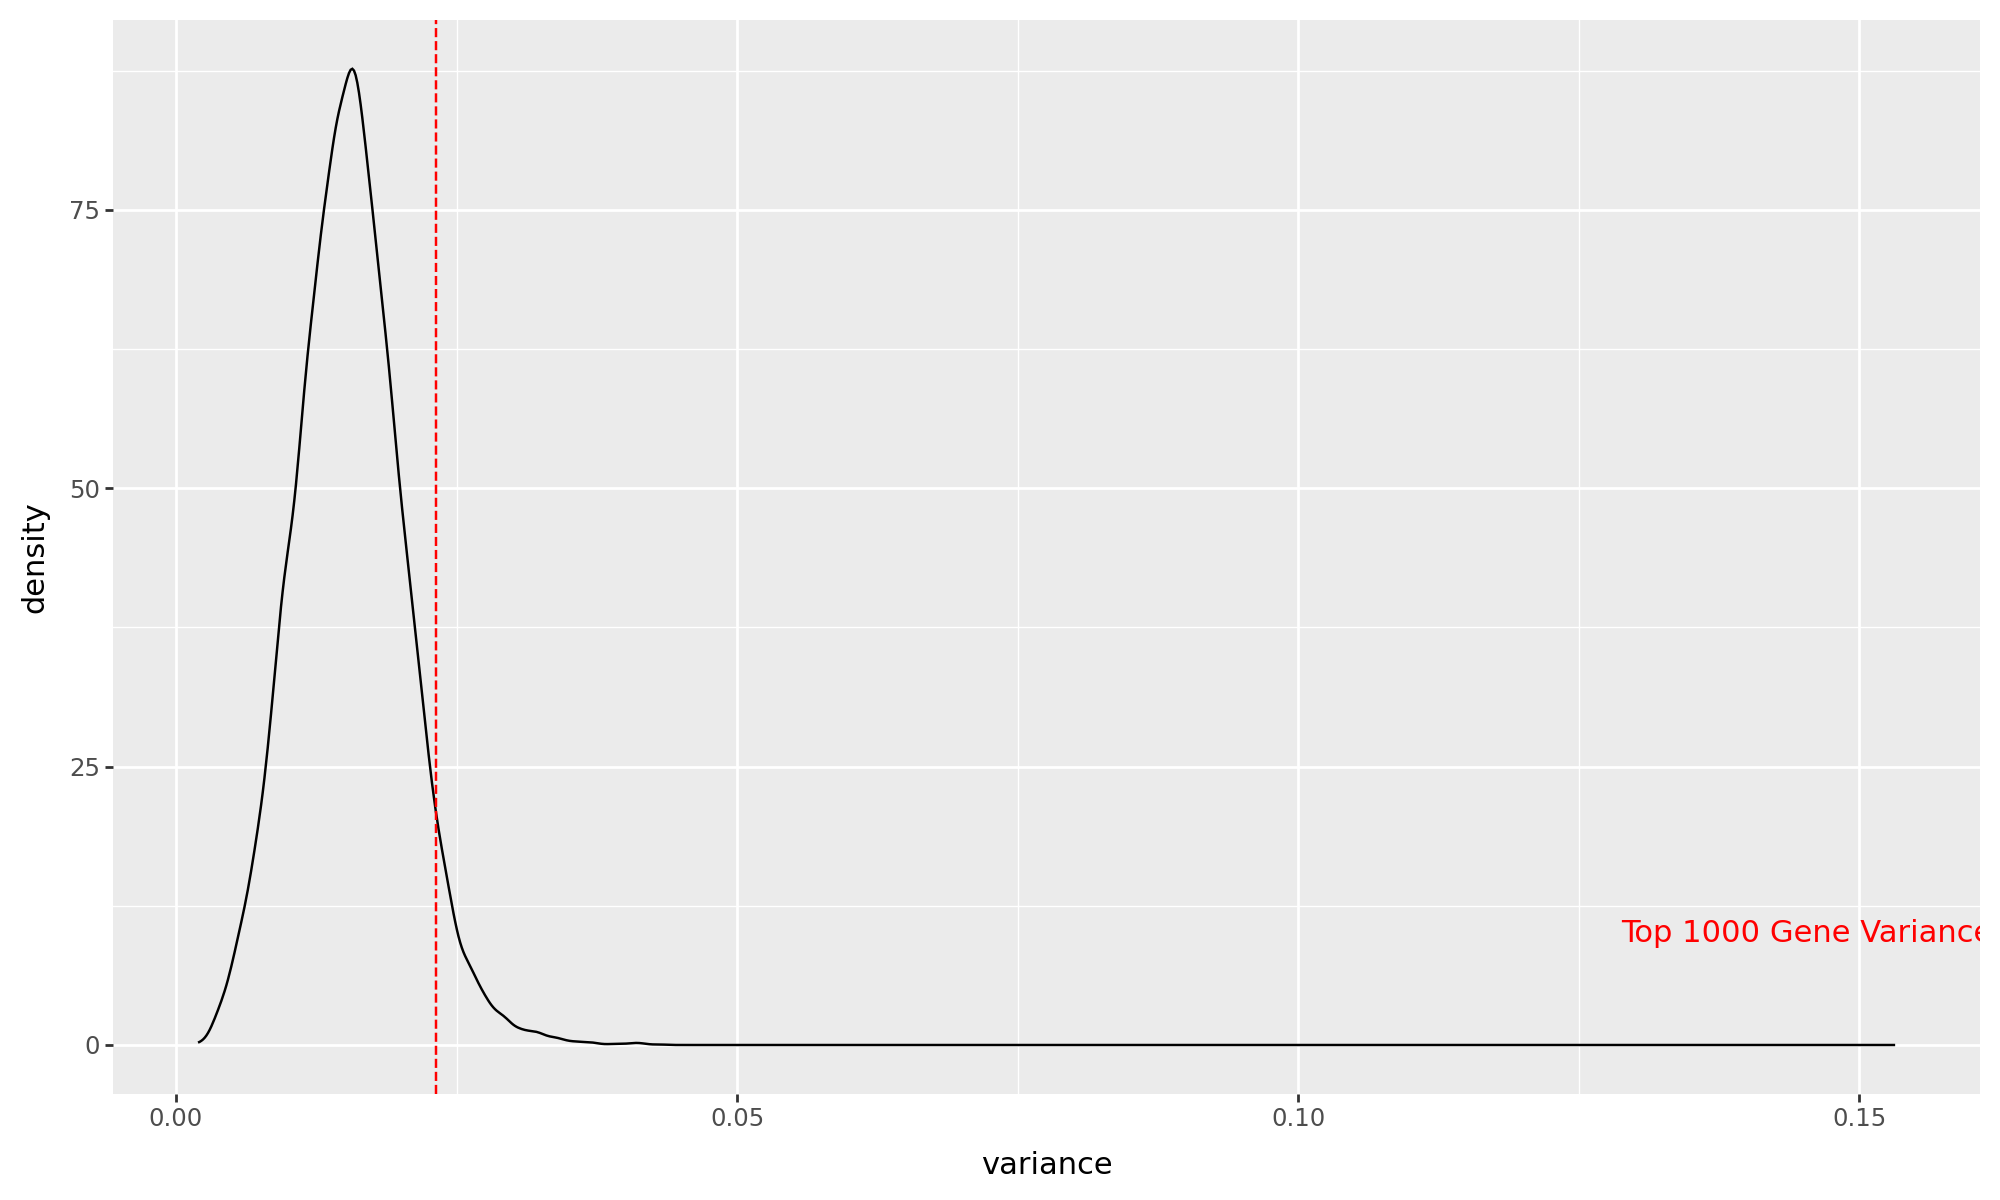

In [86]:
# finding the smallest gene variation out of the 1000 largest gene variations to set the top 1000 gene variances threshold
n = variance_df["variance"].nlargest(1000)
variance_threshold = n.astype(float).min()

# plotting variance density chart and marking the 1000 largest gene variation cutoff
variance_density_plot = (
    p9.ggplot(variance_df, p9.aes(x="variance"))
    + p9.geom_density()
    + p9.geom_vline(xintercept=variance_threshold, linetype="dashed", color="red")
    + p9.annotate(geom="text", x=variance_threshold + 0.13, y = 10, label="Top 1000 Gene Variances Threshold", color="red") 
    + p9.theme(figure_size=(10, 6))
)

# save the figure
density_path = pathlib.Path("./figures/variance_density_plot.png")
variance_density_plot.save(density_path)
variance_density_plot

In [87]:
# first create new dataframe containing gene info as well as both adult-pediatric and male-female t-test results and variance results
df = variance_df.assign(
    ttest_A_vs_P=t_test.t_stat.astype(float),
    ttest_M_vs_F=t_test_sex.t_stat.astype(float),
)

# and save the new dataframe as a .csv
testing_df_output = pathlib.Path(
    "../0.data-download/data/genes_variances_and_t-tests_df.csv"
)
df.to_csv(testing_df_output, index=False)
print(df.shape)
df.head(3)

(17107, 4)


,gene_ID,variance,ttest_A_vs_P,ttest_M_vs_F
0,A1BG (1),0.012890,2.641547,-0.704334
1,A1CF (29974),0.007995,-1.369684,1.143283
2,A2M (2),0.016177,-0.141305,1.189012


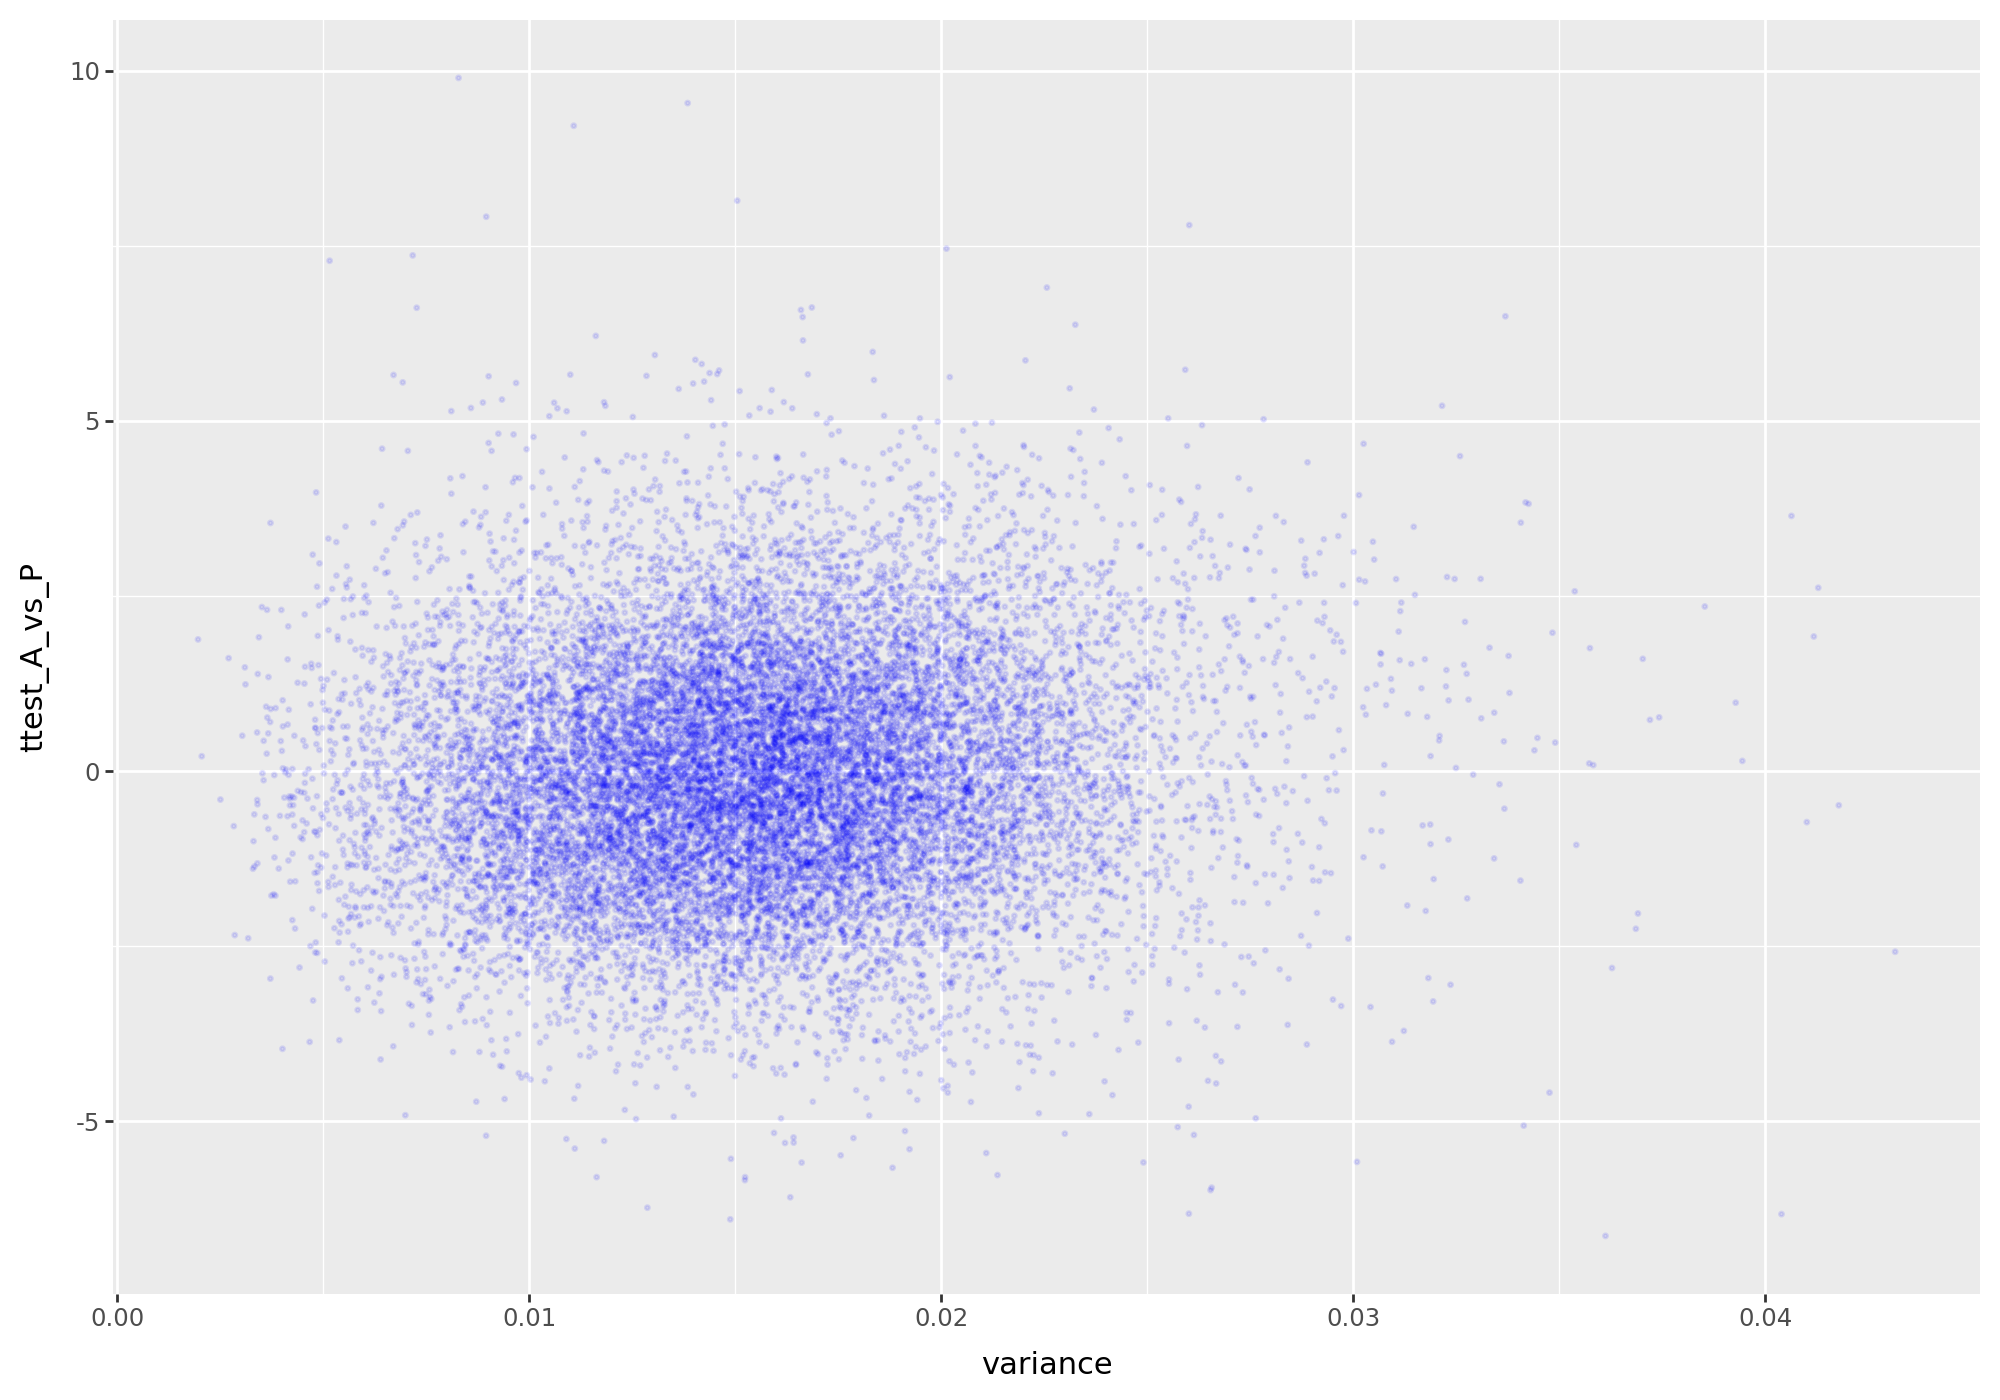

In [88]:
# plot adult-pediatric ttest versus variance
A_vs_P_by_variance_plot = (
    p9.ggplot(data=df, mapping=p9.aes(x="variance", y="ttest_A_vs_P"))
    + p9.geom_point(size=0.4, alpha=0.1, color="blue")
    + p9.theme(figure_size=(10, 7))
)

# save the figure
adult_vs_pediatric_path = pathlib.Path(
    "./figures/adult-pediatric_ttest_vs_variance.png"
)
A_vs_P_by_variance_plot.save(adult_vs_pediatric_path)
A_vs_P_by_variance_plot

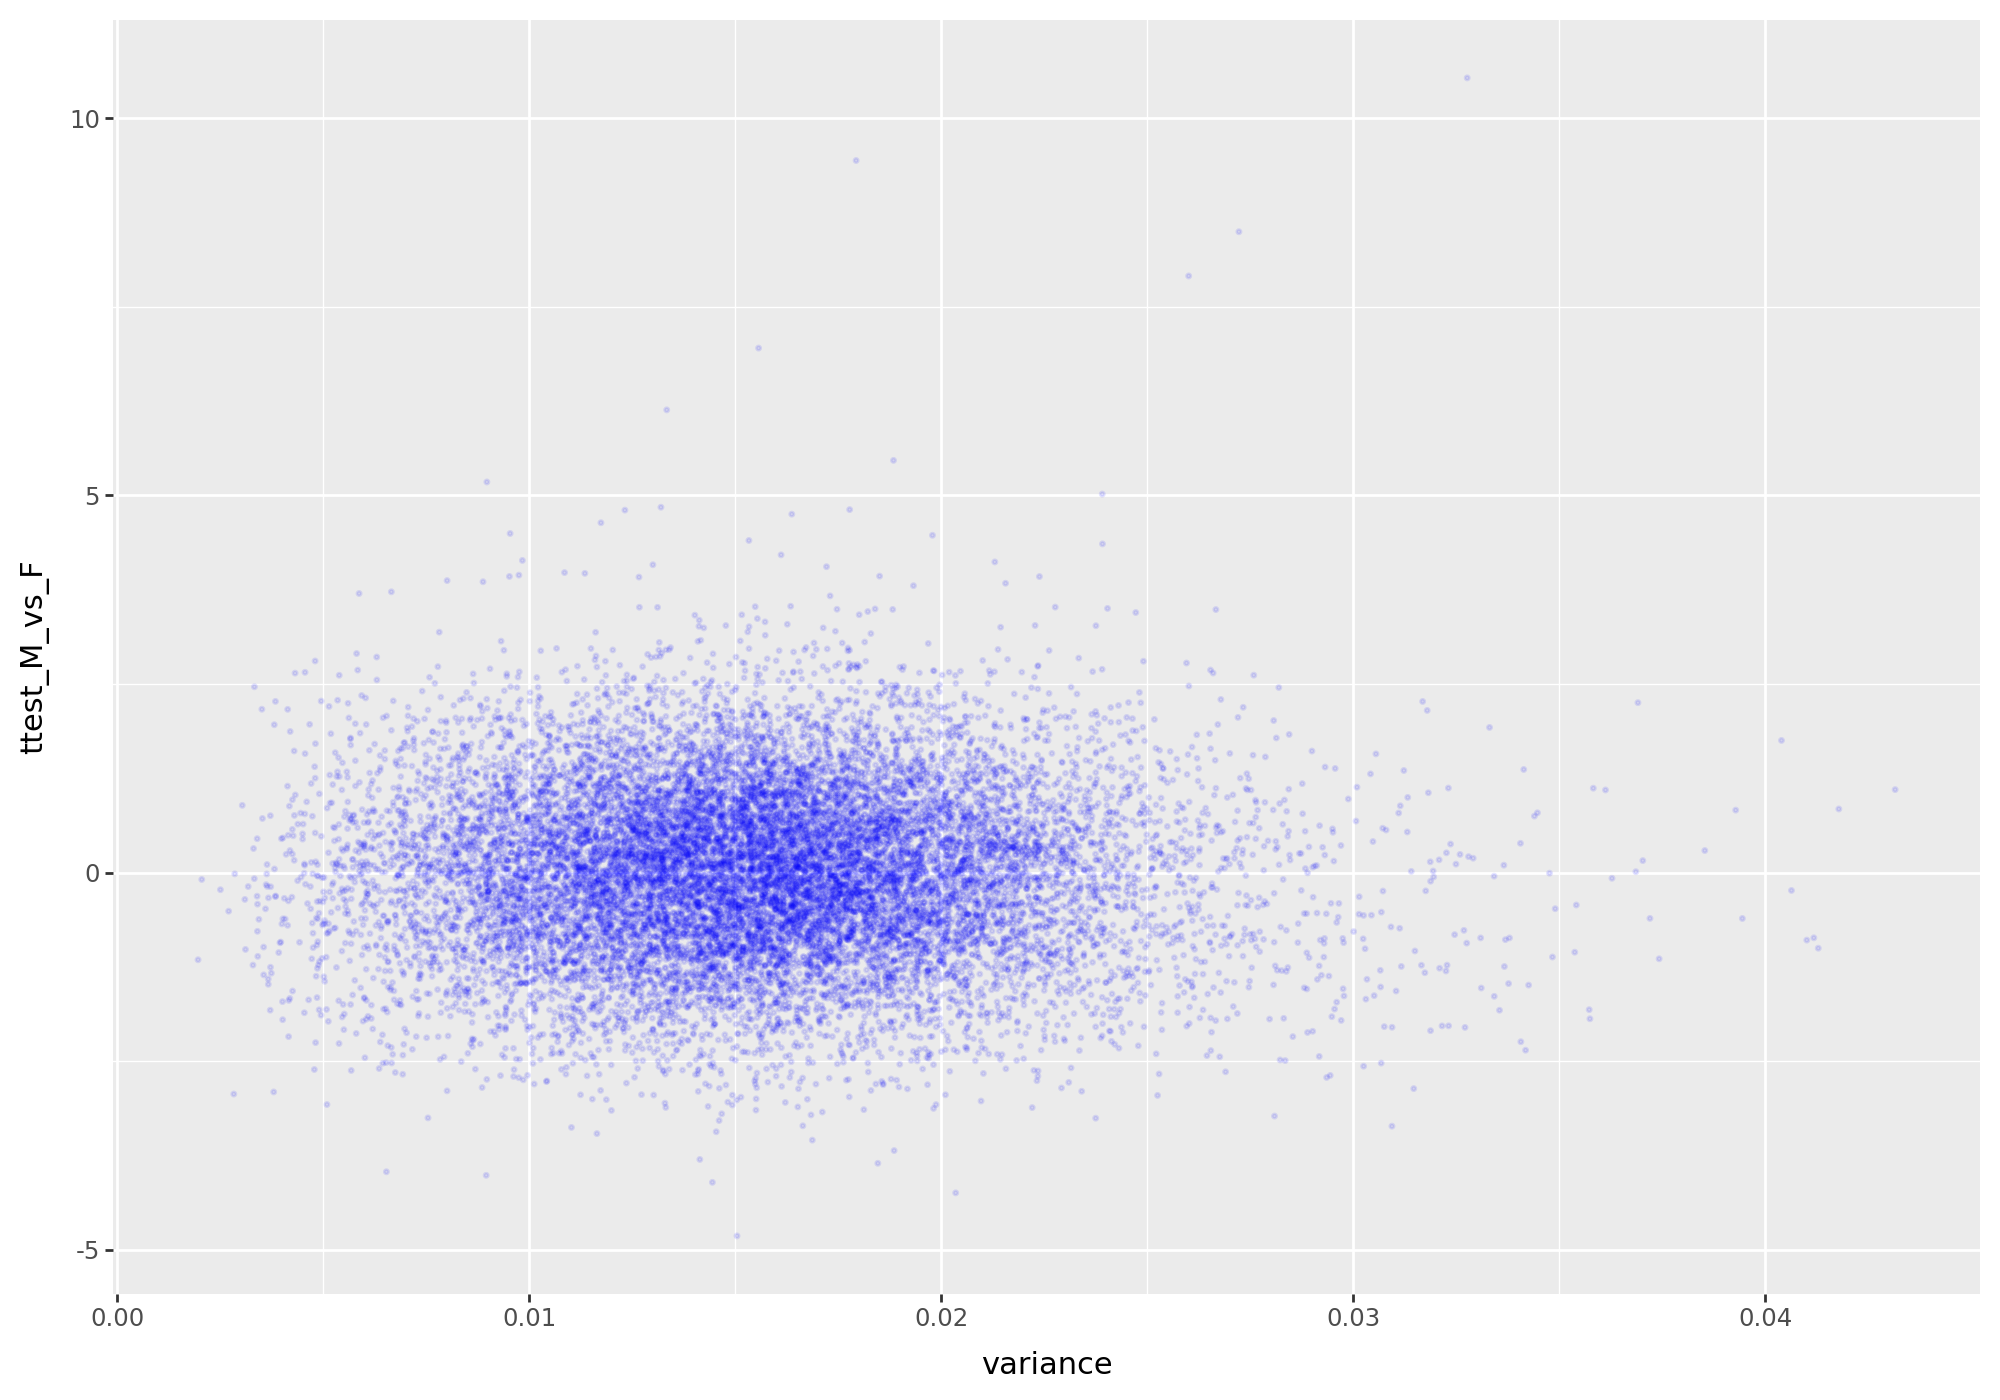

In [89]:
# plot male-female ttest versus gene variance
M_vs_F_by_variance_plot = (
    p9.ggplot(data=df, mapping=p9.aes(x="variance", y="ttest_M_vs_F"))
    + p9.geom_point(size=0.4, alpha=0.1, color="blue")
    + p9.theme(figure_size=(10, 7))
)

# save the figure
male_vs_female_path = pathlib.Path("./figures/male-female_ttest_vs_variance.png")
M_vs_F_by_variance_plot.save(male_vs_female_path)
M_vs_F_by_variance_plot